# Decision Tree Classifier for Prediction

We have experimented with various classification algorithms such as Logistic Regression, Random Forest, Support Vector Machines and Boosting algos. Through these experiments, we found that the Decision Tree Classifier provides improved performance for our dataset. We will cover data preparation, model training, evaluation, and prediction using scikit-learn's DecisionTreeClassifier.

## Imports for Data Analysis and Visualization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set_1 Datasets
Set_1=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_1.csv')
Set_1_Beneficiary_data=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_1_Beneficiarydata.csv')
Set_1_Inpatient_data=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_1_Inpatientdata.csv')
Set_1_Outpatient_data=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_1_Outpatientdata.csv')

# Set_1  Datasets
Set_2=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_2.csv')
Set_2_Beneficiary_data=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_2_Beneficiarydata.csv')
Set_2_Inpatient_data=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_2_Inpatientdata.csv')
Set_2_Outpatient_data=pd.read_csv(r'../Fresh_Aug_2025_Research_Dataset/Set_2_Outpatientdata.csv')

In [6]:
# Merging all Set_1 datasets
combined_in_out = pd.concat([Set_1_Inpatient_data, Set_1_Outpatient_data], ignore_index=True)
combined_with_benficiary = combined_in_out.merge(Set_1_Beneficiary_data, on='BeneID', how='left')
final_Set_1_df = Set_1.merge(combined_with_benficiary, on='Provider', how='inner')

# Merging all Set_2 datasets
combined_in_out = pd.concat([Set_2_Inpatient_data, Set_2_Outpatient_data], ignore_index=True)
combined_with_benficiary = combined_in_out.merge(Set_2_Beneficiary_data, on='BeneID', how='left')
final_Set_2_df = Set_2.merge(combined_with_benficiary, on='Provider', how='inner')

In [7]:
# Find the difference in column names between final_Set_1_df and final_Set_2_df
diff_cols = list(set(final_Set_1_df.columns) - set(final_Set_2_df.columns))

# Display the differing column names
print("Columns in final_Set_1_df not in final_Set_2_df:", diff_cols)

# You can also find columns in final_Set_2_df not in final_Set_1_df if needed
diff_cols_reverse = list(set(final_Set_2_df.columns) - set(final_Set_1_df.columns))
print("Columns in final_Set_2_df not in final_Set_1_df:", diff_cols_reverse)

Columns in final_Set_1_df not in final_Set_2_df: ['Unnamed: 27']
Columns in final_Set_2_df not in final_Set_1_df: []


In [8]:
final_merge_df = pd.concat([final_Set_1_df, final_Set_2_df], ignore_index=True)

print('Final dataset shape: ', final_merge_df.shape)

Final dataset shape:  (693603, 56)


In [9]:
# taking a copy of final dataset
final_merge_copy = final_merge_df.copy()
final_merge_copy.shape

(693603, 56)

In [10]:
final_merge_copy['PotentialFraud'].value_counts(dropna=False)

PotentialFraud
No     469068
Yes    224535
Name: count, dtype: int64

In [11]:
final_merge_copy['PotentialFraud'] = final_merge_copy['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_merge_copy['PotentialFraud'].value_counts(dropna=False)

PotentialFraud
0    469068
1    224535
Name: count, dtype: int64

In [12]:
# Removing 'Unnamed: 27'  column as it is a blank column
final_merge_copy = final_merge_copy.drop('Unnamed: 27', axis=1)
print('Final dataset shape after dropping "Unnamed: 27": ', final_merge_copy.shape)

Final dataset shape after dropping "Unnamed: 27":  (693603, 55)


## Data preprocessing 

In [14]:
date_columns = ['DOB', 'DOD', 'ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_columns:
    if col in final_merge_copy.columns:
        final_merge_copy[col] = pd.to_datetime(final_merge_copy[col], errors='coerce')

In [15]:
# Filling missing values with 0 or appropriate statistics (mean, median)
numeric_cols = final_merge_copy.select_dtypes(include=np.number).columns.tolist()
final_merge_copy[numeric_cols] = final_merge_copy[numeric_cols].fillna(0)

# For categorical data, filling missing values with 'unknown' or the most frequent category
categorical_cols = final_merge_copy.select_dtypes(include=['object', 'category']).columns.tolist()
final_merge_copy[categorical_cols] = final_merge_copy[categorical_cols].fillna('unknown')

In [16]:
## Lets Create Age column to the dataset
final_merge_copy['Age'] = round(((final_merge_copy['ClaimStartDt'] - final_merge_copy['DOB']).dt.days)/365)

In [17]:
# Calculate length of stay in days
final_merge_copy['LengthOfStay'] = (final_merge_copy['DischargeDt'] - final_merge_copy['AdmissionDt']).dt.days

In [18]:
# Summing  up all Chronic  conditions per beneficiary to get an overall helth risk score
final_merge_copy['TotalClaims'] = final_merge_copy.groupby('Provider')['Provider'].transform('count')

In [19]:
chronic_conditions  = [col for col in final_merge_copy.columns if 'ChronicCond_' in col]
final_merge_copy['ChronicConditionCount'] = final_merge_copy[chronic_conditions].sum(axis=1)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Ensure PotentialFraud is numeric and has no NaNs
print(final_merge_copy['PotentialFraud'].value_counts(dropna=False))
print(final_merge_copy['PotentialFraud'].unique())

# Encode categorical columns
categorical_cols = ['Gender', 'Race']
le = LabelEncoder()
for col in categorical_cols:
    final_merge_copy[col] = le.fit_transform(final_merge_copy[col].astype(str))

# Select numeric columns (excluding target)
numeric_cols = final_merge_copy.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('PotentialFraud')

# Define features (X) and target (y)
X = final_merge_copy[numeric_cols]
y = final_merge_copy['PotentialFraud']

# Check NaNs before split
print("NaN count in PotentialFraud:", y.isna().sum())
print("Unique values in PotentialFraud:", y.unique())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Check NaNs after split
print("NaN count in y_train:", y_train.isna().sum())
print("NaN count in y_test:", y_test.isna().sum())

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


PotentialFraud
0    469068
1    224535
Name: count, dtype: int64
[0 1]
NaN count in PotentialFraud: 0
Unique values in PotentialFraud: [0 1]
NaN count in y_train: 0
NaN count in y_test: 0


In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((554882, 33), (138721, 33), (554882,), (138721,))

## Model Training

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

In [24]:
# @title Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=10)
dt_clf.fit(X_train_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [25]:
Y_pred = dt_clf.predict(X_test_scaled)
Y_pred_proba = dt_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
model = 'DecisionTree'
accuracy = accuracy_score(y_test, Y_pred)
precision = precision_score(y_test, Y_pred)
recall = recall_score(y_test, Y_pred)
f1 = f1_score(y_test, Y_pred)
roc_auc = roc_auc_score(y_test, Y_pred_proba)

In [26]:
results_dict = {
    "Model": [model],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1],
    "ROC AUC Score": [roc_auc]
}

results_df = pd.DataFrame(results_dict)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,DecisionTree,0.981409,0.975809,0.966427,0.971096,0.986008


In [27]:
# Model	        Accuracy	Precision	Recall	    F1 Score	ROC AUC Score
# DecisionTree	0.979246	0.966235	0.969662	0.967945	0.976742


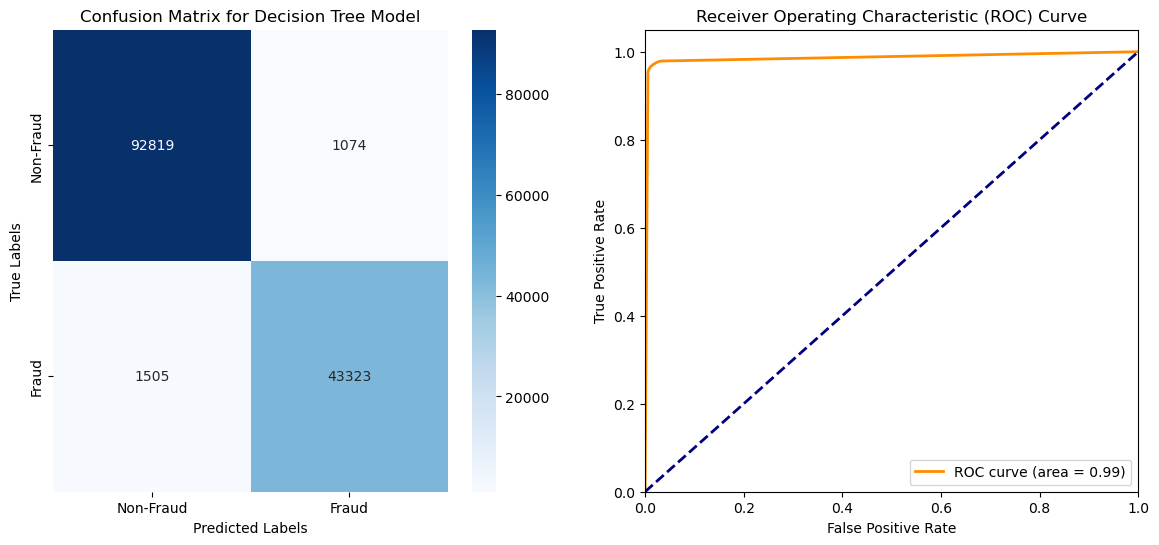

In [28]:
# Confusion Matrix
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree Model')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()